# Tes segmentasi data TGS dengan autoencoding sederhana

## Load dataset

Import library yang dibutuhkan untuk baca image 

In [1]:
# supaya warningnya nggak keluar
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

Inisiasi variabel-variabel

In [2]:
PATH = os.getcwd() # current working directory
pImage = PATH + '/all/train/images/' # directory image train
pMask = PATH + '/all/train/masks/' # directory mask train
pImaget = PATH + '/all/images/' #directory image test

iList = os.listdir(pImage) # list file image train
mList = os.listdir(pMask) # list file mask train
itList = os.listdir(pImaget) # list file image test

nFile = len(iList) # total file (jumlah image = jumlah mask)
nFilet = len(itList) # total file test

img = mpimg.imread(pImage + iList[0]) # ambil sampel 1 image untuk menentukan besar image array

In [3]:
# cek shape img
img.shape

(101, 101, 3)

In [4]:
#karena masih rgb kita convert dulu jadi grayscale (manual)
img = (img[:,:,0]+img[:,:,1]+img[:,:,2])/3

In [5]:
# cek lagi
img.shape

(101, 101)

Sekarang kita simpan semua image dalam x_train, masks dalam y_train dan test image dalam x_test

In [6]:
# disiapkan dulu matrix kosong yang ukurannya "jumlah file x panjang x tinggi"
x_train = np.empty((nFile,img.shape[0],img.shape[1]),dtype='float32')
y_train = np.empty((nFile,img.shape[0],img.shape[1]),dtype='float32')
x_test = np.empty((nFilet,img.shape[0],img.shape[1]),dtype='float32')

# masukkan semua data image ke dalam x_train dan y_train
i = 0
for f in iList:
    # data image
    img = mpimg.imread(pImage + f)
    img = (img[:,:,0]+img[:,:,1]+img[:,:,2])/3
    x_train[i,:,:] = img
    
    # data mask (dari sananya sudah grayscale)
    img = mpimg.imread(pMask + f)
    y_train[i,:,:] = img
    
    i = i + 1

# x_test juga
i = 0
for f in itList:
    # data image
    img = mpimg.imread(pImaget + f)
    img = (img[:,:,0]+img[:,:,1]+img[:,:,2])/3
    x_test[i,:,:] = img
    
    i = i + 1

selesai..
sekarang semua image ada di dalam x_train, semua mask ada di dalam y_train dan semua test data ada di x_test

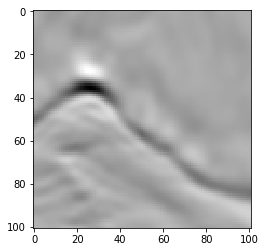

In [7]:
# tes kalo nggak percaya
plt.imshow(x_train[3],cmap='gray')

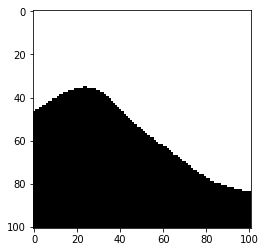

In [8]:
plt.imshow(y_train[3],cmap='gray')

## Implementasi autoencoding dengan keras

In [9]:
# import keras dulu
from keras.models import Model
from keras.layers import Dense,Input
from keras.optimizers import Adam

Using TensorFlow backend.


In [10]:
# karena kita cuma pakai MLP biasa, bukan CNN, inputnya musti di flatten dulu manual
x_train = x_train.reshape(len(x_train),np.prod(x_train.shape[1:]))
y_train = y_train.reshape(len(y_train),np.prod(y_train.shape[1:]))
x_test = x_test.reshape(len(x_test),np.prod(x_test.shape[1:]))

In [11]:
# cek dimensi x_train udah bener apa blom
x_train.shape 

(4000, 10201)

In [12]:
# sekarang inisiasi arsitektur modelnya
input_size = 10201 # jumlah node inputnya "panjang gambar x lebar gambar = 101 x 101"
hidden_size = 128 # hidden layer, yang kecil2 aja dulu
code_size = 32 # layer codenya

In [13]:
# buat modelnya pakai keras
input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size,activation='relu')(input_img)
code = Dense(code_size,activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size,activation='relu')(code)
output_img = Dense(input_size,activation='sigmoid')(hidden_2)

In [14]:
# compile model: set optimizer dan loss functionnya
autoencoder = Model(input_img,output_img)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

In [15]:
# train modelnya!! inputnya x_train outputnya y_train
autoencoder.fit(x_train,y_train,epochs=3)

Epoch 1/3
4000/4000 [==============================] - 7s 2ms/step - loss: 0.5780
Epoch 2/3
4000/4000 [==============================] - 6s 1ms/step - loss: 0.5732
Epoch 3/3
4000/4000 [==============================] - 6s 2ms/step - loss: 0.5637


accuracynya 56 % XD.
Untuk ngeplot hasilnya perlu bikin fungsi sendiri (copas punya orang dari internet)

In [16]:
def plot_autoencoder_outputs(autoencoder,n,dims):
    decoded_imgs = autoencoder.predict(x_test)
    
    # number of example digits to show
    # n = 5
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2,n,i+1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')
            
        # plot reconstruction
        ax = plt.subplot(2,n,i+1+n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

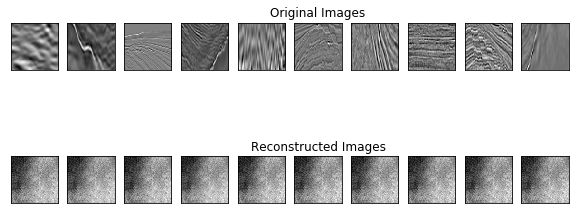

In [17]:
# coba dites outputnya gimana
plot_autoencoder_outputs(autoencoder,10,(101,101))